<a href="https://colab.research.google.com/github/kkoma2623/VisualComputing/blob/master/Conditional_DCGAN_(TensorFlow_2)_kkoma2623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp

from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.

Python: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Numpy: 1.18.4
Tensorflow:  2.2.0
Keras:  2.3.0-tf
Tensorflow Probability:  0.10.0


In [0]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [-1, 1] (* tanh을 거친 값과 비교해야 하기 때문...)
train_images = (train_images - 127.5) / 127.5 
test_images = (test_images - 127.5) / 127.5 

# tensorflow probablity layer가 float32를 입력을 받기 때문에 float64를 float32로 캐스팅
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# 데이터가 [-1, 1] 사이로 정규화 되었는지 확인
print(np.amin(train_images), np.amax(train_images))


print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels[0].dtype)

-1.0 1.0
(60000, 28, 28)
(10000, 28, 28)
(28, 28)
float32
uint8


In [0]:
# 트레이닝 데이터 배치 사이즈 결정 및 셔플
BUFFER_SIZE = 60000
BATCH_SIZE = 256


train_onehot_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_onehot_labels  = tf.keras.utils.to_categorical(test_labels, num_classes=10)


# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_onehot_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Dense 층으로 Generator 모델을 작성해보았다.
* Dense 층으로 작성하였기 때문에 노이즈와 라벨을 벡터 형식으로 주었다.
* noise_input (100,), label_input (10,)
* noise_input + label_input (concatenate) -> (110) -> (256) -> (512) ->(1024) -> (784) -> (28,28)

In [0]:
# Generator 모델 작성

noise_input = tf.keras.Input(shape=(100,), name='noise')
label_input = tf.keras.Input(shape=(10,),  name='onehot_label')

G_x = layers.concatenate([noise_input, label_input])
G_x = layers.Dense(256, use_bias=False)(G_x)      # 이후 batch normalization을 시행하므로 bias는 학습하지 않음.
G_x = layers.BatchNormalization()(G_x)
G_x = layers.LeakyReLU()(G_x)
G_x = layers.Dense(512)(G_x)
G_x = layers.BatchNormalization()(G_x)
G_x = layers.LeakyReLU()(G_x)
G_x = layers.Dense(1024)(G_x)
G_x = layers.BatchNormalization()(G_x)
G_x = layers.LeakyReLU()(G_x)
G_x = layers.Dense(784)(G_x)
G_x = layers.BatchNormalization()(G_x)
G_x = tf.keras.activations.tanh(G_x)
G_y_pred = layers.Reshape(target_shape=(28,28))(G_x) # 28x28 크기 gray 영상으로 크기 변환

G = tf.keras.Model(inputs=[noise_input, label_input], outputs=G_y_pred)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
onehot_label (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           noise[0][0]                      
                                                                 onehot_label[0][0]               
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          28160       concatenate[0][0]            

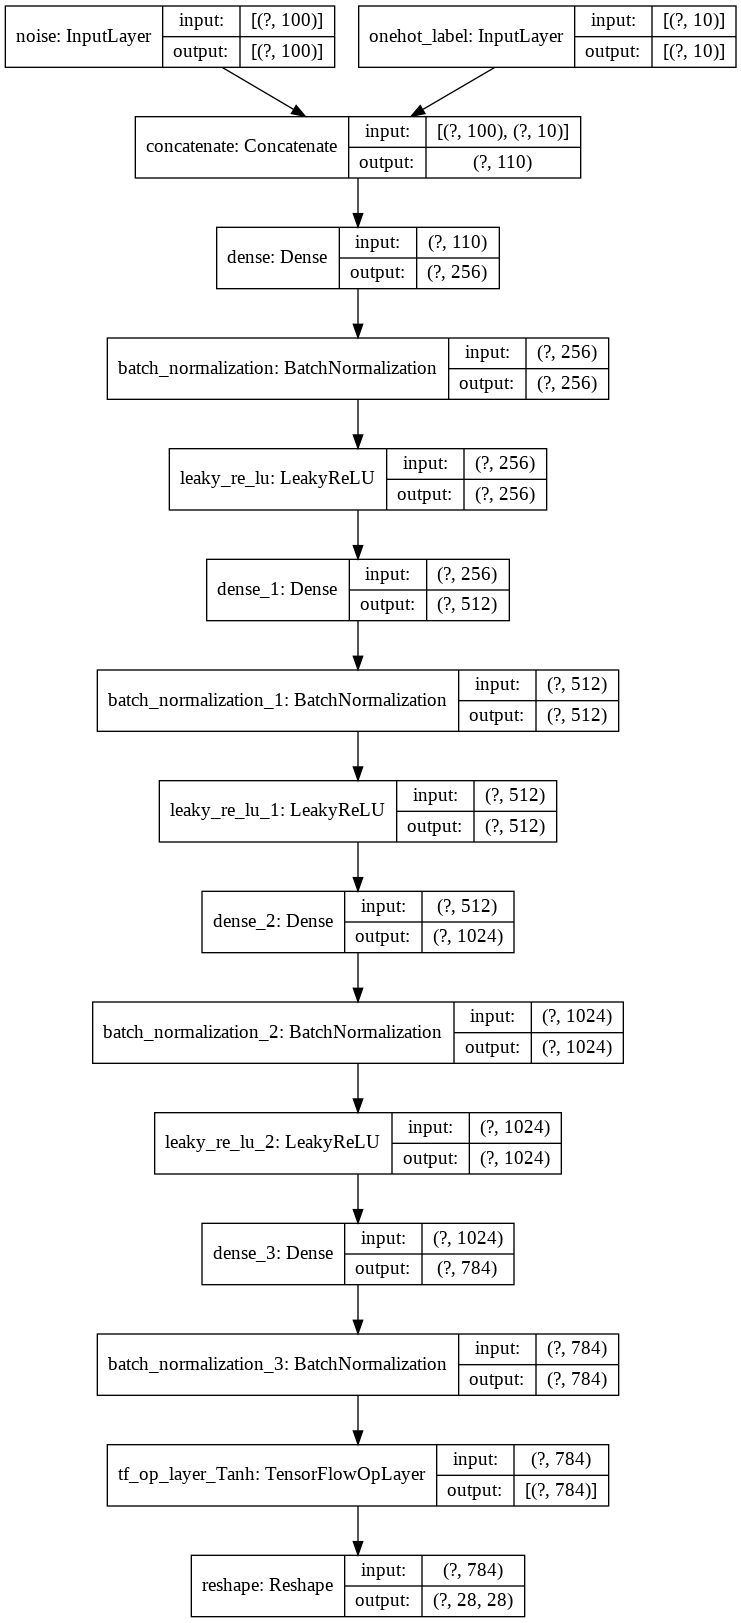

In [0]:
G.summary()
tf.keras.utils.plot_model(G, 'dense_generator.png', show_shapes=True)

## Dense로 Discriminator 모델을 작성하였다.
* Dense 층으로 구성하였기 때문에 condition을 벡터 형식으로 주었다.
* Dense 층으로 구성하였기 때문에 (28,28) 이미지를 (784) 로 변환하였다. 채널은 하나만 사용하였기 때문에 생략하였다.
* image_input (28,28) -> (28*28) -> image_input (28 * 28) + label_input (10) (concatenate) -> (1024) -> (512) -> (256) -> (1)

In [0]:
# Discriminator 모델 작성

image_input = tf.keras.Input(shape=(28, 28), name='image')
label_input = tf.keras.Input(shape=(10,),  name='onehot_label')

image = layers.Reshape(target_shape=(28 * 28, ))(image_input)

D_x = layers.concatenate([image, label_input], axis=-1)
D_x = layers.Dense(1024)(D_x)
D_x = layers.LeakyReLU()(D_x)
D_x = layers.Dropout(0.3)(D_x)
D_x = layers.Dense(512)(D_x)
D_x = layers.Dropout(0.3)(D_x)
D_x = layers.Dense(256)(D_x)
D_y_pred = layers.Dense(1)(D_x)

D = tf.keras.Model(inputs=[image_input, label_input], outputs=D_y_pred)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 784)          0           image[0][0]                      
__________________________________________________________________________________________________
onehot_label (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           reshape_1[0][0]                  
                                                                 onehot_label[0][0]         

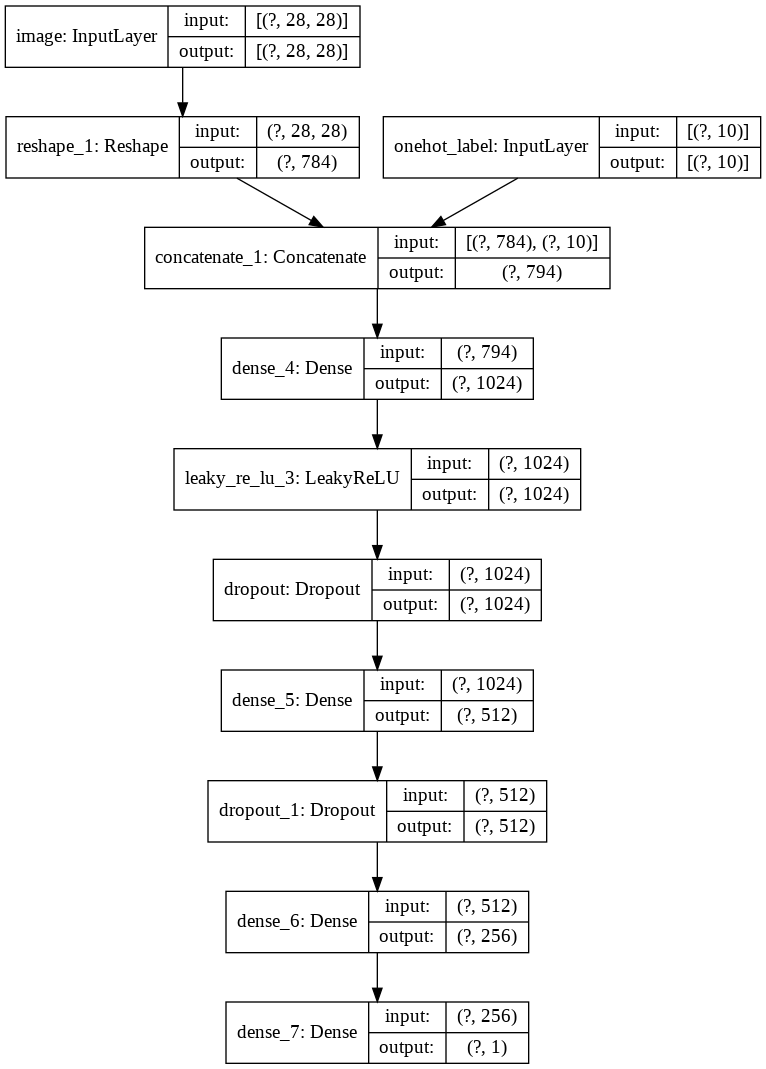

In [0]:
D.summary()
tf.keras.utils.plot_model(D, 'dense_discriminator.png', show_shapes=True)

## Generator가 만들어 낸 노이즈 이미지 테스트 해보기
* 아직 학습을 하지 않아서 의미 없는 값을 출력한다.

[one example test] rand_label: [9]


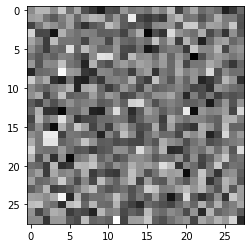

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

rand_label = np.random.randint(10, size=(1,))
print("[one example test] rand_label:", rand_label)

test_noise = tf.random.normal([1, 100])
test_label = tf.keras.utils.to_categorical(rand_label, num_classes=10)
fake_image_test = G([test_noise, test_label], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test[0], cmap='gray')

## Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함

In [0]:
decision = D([fake_image_test, test_label], training=False)  # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
print(decision)

tf.Tensor([[0.11227779]], shape=(1, 1), dtype=float32)


In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
# Generator loss 정의

def G_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

## 일단 50 에포크로 설정하였다.

In [0]:
# 학습 루프 설정

EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step(real_images, real_labels):
  
  assert real_images.shape[0] == real_labels.shape[0]
  
  minibatch_size = real_labels.shape[0]
  noises = tf.random.normal([minibatch_size, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G([noises, real_labels], training=True)
    
    real_output = D([real_images, real_labels], training=True)
    fake_output = D([fake_images, real_labels], training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables)) 
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

In [0]:
def test_step(real_images, real_labels):
  
  assert real_images.shape[0] == real_labels.shape[0]
  
  minibatch_size = real_labels.shape[0]
  noises = tf.random.normal([minibatch_size, noise_dim])
  
  fake_images = G([noises, real_labels], training=False)
  
  real_output = D([real_images, real_labels], training=False)
  fake_output = D([fake_images, real_labels], training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for i, batch in enumerate(dataset):
      train_step(batch[0], batch[1])
      if i == 0:
        test_step(batch[0], batch[1])
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

## Generator와 Discriminator의 loss를 관찰해보았다.
* 둘 다 loss가 줄어드는 방향으로만 학습하지 않고 loss가 줄었다가 늘었다가를 반복하며 진동한다.
* 하지만 Generator의 로스는 전반적으로 줄어들었다. 하지만 마지막 에포크에서의 로스를 보면 값이 큰 것을 알 수 있다.
* 반면에 Disccriminator의 loss는 전반적으로 올라가지만 마지막 에포크에서의 로스를 보면 값이 작은 것을 알 수 있다.
* 이 결과를 통해 Generator가 생성하는 이미지는 Discriminator가 잘 분별한 다고 예상해볼 수 있다.
* 하지만 Generator의 마지막 로스 값이 처음 로스 값보다 줄어들었으므로 이미지를 잘 생성해내지 못하면 에포크를 늘려서 학습을 더 시켜보는 방향으로 성능을 올릴 수 있겠다.

In [0]:
# 학습!!!
%%time
train(train_dataset, EPOCHS)

Generator loss: 0.53230536 Discriminator loss: 1.1820483
Time for epoch 1 is 4.080359220504761 sec
Generator loss: 13.46676 Discriminator loss: 0.00012005178
Time for epoch 2 is 1.6140186786651611 sec
Generator loss: 27.451042 Discriminator loss: 0.001196093
Time for epoch 3 is 1.5011630058288574 sec
Generator loss: 43.467655 Discriminator loss: 0.00018117327
Time for epoch 4 is 1.5085108280181885 sec
Generator loss: 41.60836 Discriminator loss: 0.00029482748
Time for epoch 5 is 1.5068299770355225 sec
Generator loss: 38.680458 Discriminator loss: 3.8926388e-05
Time for epoch 6 is 1.5539405345916748 sec
Generator loss: 27.492851 Discriminator loss: 4.5028773e-06
Time for epoch 7 is 1.4885494709014893 sec
Generator loss: 24.238882 Discriminator loss: 1.6313996e-05
Time for epoch 8 is 1.5437531471252441 sec
Generator loss: 24.45361 Discriminator loss: 2.6606817e-06
Time for epoch 9 is 1.5145413875579834 sec
Generator loss: 24.003695 Discriminator loss: 3.8150083e-06
Time for epoch 10 is 1

## Generator가 만들어 낸 노이즈 이미지 테스트 해보기
* random한 라벨을 뽑아서 rand_labels에 담아주었다.
* random하게 뽑은 라벨 수 만큼 normal distribution을 따르는 노이즈를 만들었다.
* 노이즈와 라벨을 입력으로 줘서 생성을 해보았다.
* 노이즈를 완벽히 제거하지도 못했고 손글씨를 생성하지도 못했다. 하지만 에포크를 50 밖에 주지 않아서 제대로 학습이 된 것 같지 않다.
* 에포크를 늘려서 실험을 해보겠다.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


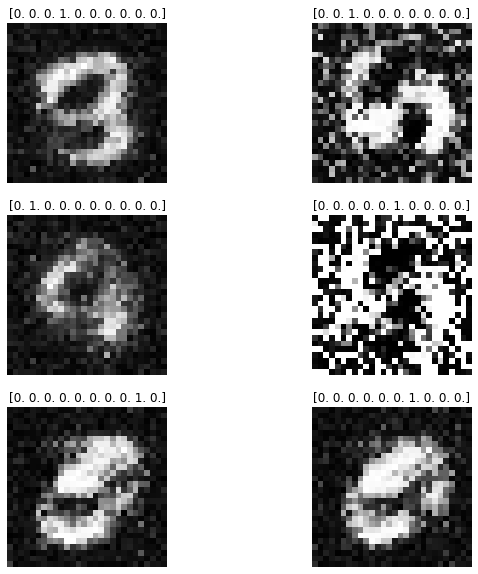

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

rand_labels = np.random.randint(10, size=(50,))

noises = tf.random.normal([50, 100])
rand_labels = tf.keras.utils.to_categorical(rand_labels, num_classes=10)

generated_image = G([noises, rand_labels], training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,0].title.set_text(rand_labels[0])
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[0,1].title.set_text(rand_labels[1])
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,0].title.set_text(rand_labels[2])
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[1,1].title.set_text(rand_labels[3])
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,0].title.set_text(rand_labels[4])
axes[2,1].imshow(generated_image[5], cmap='gray')
axes[2,1].title.set_text(rand_labels[5])

plt.show()

## 다음은 직접 rand_label을 바꿔가며 확인할 수 있도록 하였다.
* widgets 라이브러리를 사용하였다.

In [0]:
## 디코더의 테스트 입력 설정

import matplotlib.pyplot as plt
import ipywidgets as widgets

i=widgets.IntSlider(min=0, max=49)
ui = widgets.HBox([i])

# Generator가 만들어 낸 노이즈 이미지 테스트 해보기


rand_labels = np.random.randint(10, size=(50,))

noises = tf.random.normal([50, 100])
rand_labels = tf.keras.utils.to_categorical(rand_labels, num_classes=10)

generated_image = G([noises, rand_labels], training=False)



def z_test(i):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  for ax in axes.flat:
    ax.axis('off')
  axes[0,0].imshow(generated_image[i], cmap='gray')
  number = np.where(1 == rand_labels[i])
  axes[0,0].title.set_text("rand_label number = " + str(number[0][0]))
  plt.show()

out = widgets.interactive_output(z_test, {'i':i})
display(ui, out)

Output()

## 에포크가 50 밖에 되지 않아서 제대로 생성을 하지 못한 것 같다.
* 에포크를 300으로 늘려서 실험을 하겠다.
* 이전에 사용했던 모델의 구조를 바꾸지 않았다.

In [0]:
# Generator 모델 작성

noise_input_2 = tf.keras.Input(shape=(100,), name='noise')
label_input_2 = tf.keras.Input(shape=(10,),  name='onehot_label')

G_x_2 = layers.concatenate([noise_input_2, label_input_2])
G_x_2 = layers.Dense(256, use_bias=False)(G_x_2)      # 이후 batch normalization을 시행하므로 bias는 학습하지 않음.
G_x_2 = layers.BatchNormalization()(G_x_2)
G_x_2 = layers.LeakyReLU()(G_x_2)
G_x_2 = layers.Dense(512)(G_x_2)
G_x_2 = layers.BatchNormalization()(G_x_2)
G_x_2 = layers.LeakyReLU()(G_x_2)
G_x_2 = layers.Dense(1024)(G_x_2)
G_x_2 = layers.BatchNormalization()(G_x_2)
G_x_2 = layers.LeakyReLU()(G_x_2)
G_x_2 = layers.Dense(784)(G_x_2)
G_x_2 = layers.BatchNormalization()(G_x_2)
G_x_2 = tf.keras.activations.tanh(G_x_2)
G_y_pred_2 = layers.Reshape(target_shape=(28,28))(G_x_2) # 28x28 크기 gray 영상으로 크기 변환

G_2 = tf.keras.Model(inputs=[noise_input_2, label_input_2], outputs=G_y_pred_2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
onehot_label (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           noise[0][0]                      
                                                                 onehot_label[0][0]               
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          28160       concatenate_2[0][0]        

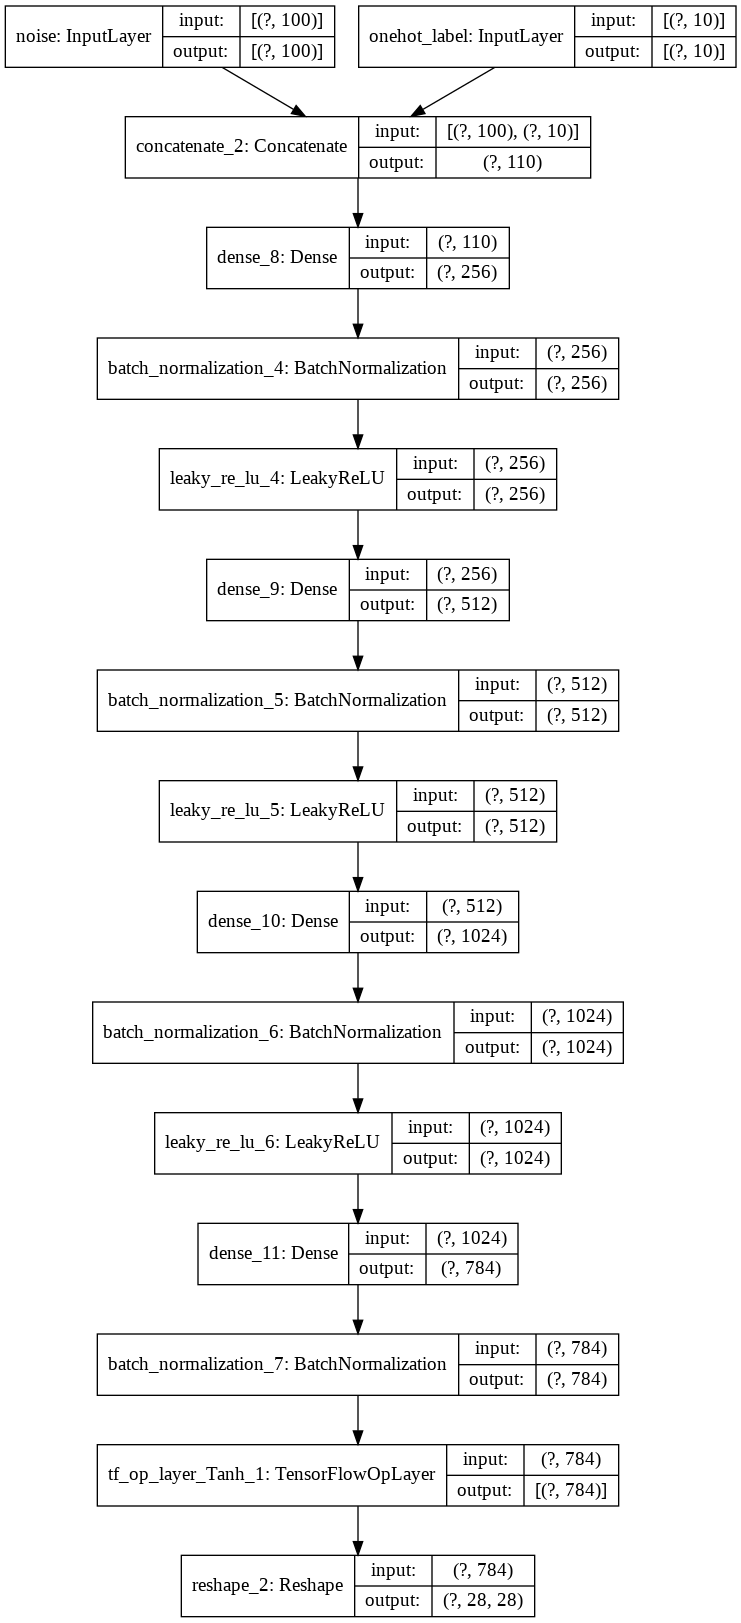

In [0]:
G_2.summary()
tf.keras.utils.plot_model(G_2, 'dense_generator2.png', show_shapes=True)

## Discriminator의 모델 구조도 변경을 하지 않았다.

In [0]:
# Discriminator 모델 작성

image_input_2 = tf.keras.Input(shape=(28, 28), name='image')
label_input_2 = tf.keras.Input(shape=(10,),  name='onehot_label')

image_2 = layers.Reshape(target_shape=(28 * 28, ))(image_input_2)

D_x_2 = layers.concatenate([image_2, label_input_2], axis=-1)
D_x_2 = layers.Dense(1024)(D_x_2)
D_x_2 = layers.LeakyReLU()(D_x_2)
D_x_2 = layers.Dropout(0.3)(D_x_2)
D_x_2 = layers.Dense(512)(D_x_2)
D_x_2 = layers.Dropout(0.3)(D_x_2)
D_x_2 = layers.Dense(256)(D_x_2)
D_y_pred_2 = layers.Dense(1)(D_x_2)

D_2 = tf.keras.Model(inputs=[image_input_2, label_input_2], outputs=D_y_pred_2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 784)          0           image[0][0]                      
__________________________________________________________________________________________________
onehot_label (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 794)          0           reshape_3[0][0]                  
                                                                 onehot_label[0][0]         

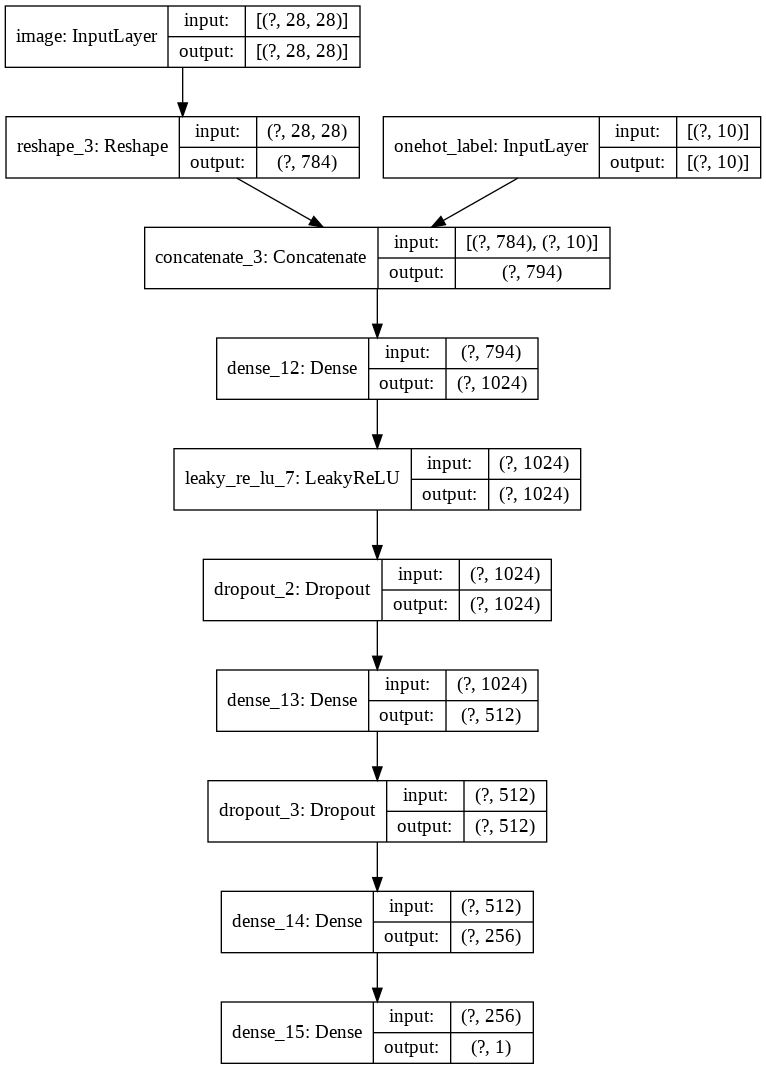

In [0]:
D_2.summary()
tf.keras.utils.plot_model(D_2, 'dense_discriminator2.png', show_shapes=True)

## 이전과 마찬가지로 학습을 하지 않았기 때문에 의미있는 값을 출력하지 않는다.

[one example test] rand_label: [2]


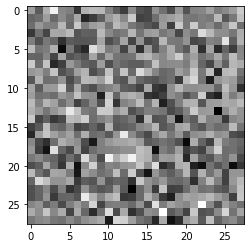

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

rand_label_2 = np.random.randint(10, size=(1,))
print("[one example test] rand_label:", rand_label_2)

test_noise_2 = tf.random.normal([1, 100])
test_label_2 = tf.keras.utils.to_categorical(rand_label_2, num_classes=10)
fake_image_test_2 = G_2([test_noise_2, test_label_2], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test_2[0], cmap='gray')

In [0]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.

decision_2 = D_2([fake_image_test_2, test_label_2], training=False)  # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
print(decision_2)

tf.Tensor([[-0.17361782]], shape=(1, 1), dtype=float32)


In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy_2 = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss_2(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
# Generator loss 정의

def G_loss_2(fake_output):
  return cross_entropy_2(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer_2 = tf.keras.optimizers.Adam(1e-4)
D_optimizer_2 = tf.keras.optimizers.Adam(1e-4)

## 에포크를 300으로 설정하였다.

In [0]:
# 학습 루프 설정

EPOCHS_2 = 300
noise_dim_2 = 100

seed_2 = tf.random.normal([BATCH_SIZE, noise_dim_2])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step_2(real_images, real_labels):
  
  assert real_images.shape[0] == real_labels.shape[0]
  
  minibatch_size = real_labels.shape[0]
  noises = tf.random.normal([minibatch_size, noise_dim_2])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G_2([noises, real_labels], training=True)
    
    real_output = D_2([real_images, real_labels], training=True)
    fake_output = D_2([fake_images, real_labels], training=True)
    
    gen_loss_2 = G_loss_2(fake_output)
    dsc_loss_2 = D_loss_2(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss_2, G_2.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss_2, D_2.trainable_variables)
  
  G_optimizer_2.apply_gradients(zip(gen_gradients, G_2.trainable_variables)) 
  D_optimizer_2.apply_gradients(zip(dsc_gradients, D_2.trainable_variables))

In [0]:
def test_step_2(real_images, real_labels):
  
  assert real_images.shape[0] == real_labels.shape[0]
  
  minibatch_size = real_labels.shape[0]
  noises = tf.random.normal([minibatch_size, noise_dim_2])
  
  fake_images = G_2([noises, real_labels], training=False)
  
  real_output = D_2([real_images, real_labels], training=False)
  fake_output = D_2([fake_images, real_labels], training=False)    
  
  gen_loss = G_loss_2(fake_output)
  dsc_loss = D_loss_2(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train_2(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for i, batch in enumerate(dataset):
      train_step_2(batch[0], batch[1])
      if i == 0:
        test_step_2(batch[0], batch[1])
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

## Generator와 Discriminator의 loss를 관찰하였다.
* 이전과 마찬가지로 로스가 줄어들지만 하지 않고 둘 다 로스가 줄었다가 늘었다가를 반복하며 진동한다.
* 하지만 Generator의 loss는 전반적으로 줄어들었지만 Discriminator의 loss는 전반적으로 늘어났다. 이 결과를 통해 Generator가 학습이 잘 돼서 Discriminator가 잘 분별하지 못하도록 손글씨 이미지를 생성한 것이라고 예상해본다.

In [0]:
# 학습!!!
%%time
train_2(train_dataset, EPOCHS_2)

Generator loss: 0.72818214 Discriminator loss: 0.90803516
Time for epoch 1 is 4.027119874954224 sec
Generator loss: 15.342686 Discriminator loss: 0.00028464833
Time for epoch 2 is 1.490429401397705 sec
Generator loss: 28.731823 Discriminator loss: 0.0012306966
Time for epoch 3 is 1.494213342666626 sec
Generator loss: 41.252266 Discriminator loss: 7.042686e-05
Time for epoch 4 is 1.5179924964904785 sec
Generator loss: 35.54734 Discriminator loss: 0.00017231233
Time for epoch 5 is 1.5508558750152588 sec
Generator loss: 36.77234 Discriminator loss: 1.1484326e-05
Time for epoch 6 is 1.5074067115783691 sec
Generator loss: 31.041658 Discriminator loss: 1.716025e-05
Time for epoch 7 is 1.5110747814178467 sec
Generator loss: 26.924343 Discriminator loss: 3.7169361e-06
Time for epoch 8 is 1.4896223545074463 sec
Generator loss: 27.756466 Discriminator loss: 1.0536978e-05
Time for epoch 9 is 1.5058329105377197 sec
Generator loss: 27.277246 Discriminator loss: 7.0861784e-06
Time for epoch 10 is 1.

## 에포크를 늘려서 그런지 이전보다 의미있게 손글씨를 생성해낸다.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


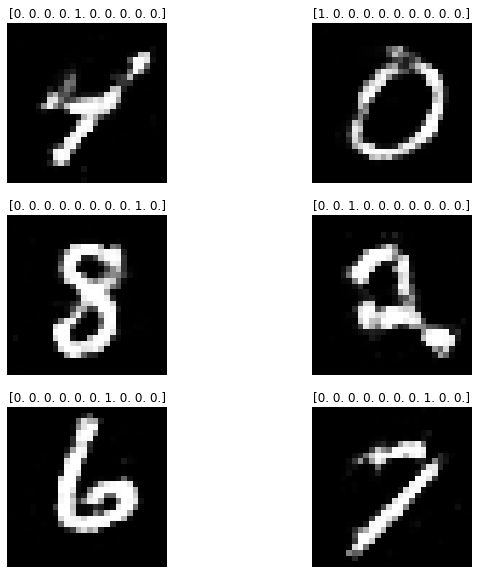

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

rand_labels_2 = np.random.randint(10, size=(50,))

noises_2 = tf.random.normal([50, 100])
rand_labels_2 = tf.keras.utils.to_categorical(rand_labels_2, num_classes=10)

generated_image_2 = G_2([noises_2, rand_labels_2], training=False)

fig_2, axes_2 = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes_2.flat:
  ax.axis('off')
axes_2[0,0].imshow(generated_image_2[0], cmap='gray')
axes_2[0,0].title.set_text(rand_labels_2[0])
axes_2[0,1].imshow(generated_image_2[1], cmap='gray')
axes_2[0,1].title.set_text(rand_labels_2[1])
axes_2[1,0].imshow(generated_image_2[2], cmap='gray')
axes_2[1,0].title.set_text(rand_labels_2[2])
axes_2[1,1].imshow(generated_image_2[3], cmap='gray')
axes_2[1,1].title.set_text(rand_labels_2[3])
axes_2[2,0].imshow(generated_image_2[4], cmap='gray')
axes_2[2,0].title.set_text(rand_labels_2[4])
axes_2[2,1].imshow(generated_image_2[5], cmap='gray')
axes_2[2,1].title.set_text(rand_labels_2[5])

plt.show()

In [0]:
## 디코더의 테스트 입력 설정

import matplotlib.pyplot as plt
import ipywidgets as widgets

i_2=widgets.IntSlider(min=0, max=49)
ui_2 = widgets.HBox([i_2])

# Generator가 만들어 낸 노이즈 이미지 테스트 해보기


rand_labels_2 = np.random.randint(10, size=(50,))

noises_2 = tf.random.normal([50, 100])
rand_labels_2 = tf.keras.utils.to_categorical(rand_labels_2, num_classes=10)

generated_image_2 = G_2([noises_2, rand_labels_2], training=False)



def z_test_2(i):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  for ax in axes.flat:
    ax.axis('off')
  axes[0,0].imshow(generated_image_2[i], cmap='gray')
  number = np.where(1 == rand_labels_2[i])
  axes[0,0].title.set_text("rand_label number = " + str(number[0][0]))
  plt.show()

out_2 = widgets.interactive_output(z_test_2, {'i':i_2})
display(ui_2, out_2)

Output()

## 이번에는 에포크 300을 설정하고 학습 데이터를 전처리 해보아서 실험을 해보겠다.
* 학습 데이터를 전처리를 하여 -1과 1의 값만 갖도록 실험을 해보겠다.
* 0 이상이면 1.0 값을, 0 미만이면 -1.0 값을 가지고 학습데이터를 전처리 해보았다.
* 이전의 실험들과 모델의 구조는 동일하다.

In [0]:
(train_images_3, train_labels), (test_images_3, test_labels) = mnist.load_data()

# Normalize the images to [-1, 1] (* tanh을 거친 값과 비교해야 하기 때문...)
train_images_3 = (train_images_3 - 127.5) / 127.5 
test_images_3 = (test_images_3 - 127.5) / 127.5 

# print(train_images_3[0])
train_images_3[train_images_3 >= 0.0] = 1.0
train_images_3[train_images_3 <  0.0] = -1.0
test_images_3[test_images_3 >= 0.0] = 1.0
test_images_3[test_images_3 <  0.0] = -1.0

# tensorflow probablity layer가 float32를 입력을 받기 때문에 float64를 float32로 캐스팅
train_images_3 = train_images_3.astype('float32')
test_images_3 = test_images_3.astype('float32')

# 데이터가 [-1, 1] 사이로 정규화 되었는지 확인
print(np.amin(train_images_3), np.amax(train_images_3))


print(train_images_3.shape)
print(test_images_3.shape)
print(train_images_3[0].shape)
print(train_images_3[0][0][0].dtype)
print(train_labels[0].dtype)

# Batch and shuffle the data
train_dataset_3 = tf.data.Dataset.from_tensor_slices((train_images_3, train_onehot_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

-1.0 1.0
(60000, 28, 28)
(10000, 28, 28)
(28, 28)
float32
uint8


In [0]:
# Generator 모델 작성

noise_input_3 = tf.keras.Input(shape=(100,), name='noise')
label_input_3 = tf.keras.Input(shape=(10,),  name='onehot_label')

G_x_3 = layers.concatenate([noise_input_3, label_input_3])
G_x_3 = layers.Dense(256, use_bias=False)(G_x_3)      # 이후 batch normalization을 시행하므로 bias는 학습하지 않음.
G_x_3 = layers.BatchNormalization()(G_x_3)
G_x_3 = layers.LeakyReLU()(G_x_3)
G_x_3 = layers.Dense(512)(G_x_3)
G_x_3 = layers.BatchNormalization()(G_x_3)
G_x_3 = layers.LeakyReLU()(G_x_3)
G_x_3 = layers.Dense(1024)(G_x_3)
G_x_3 = layers.BatchNormalization()(G_x_3)
G_x_3 = layers.LeakyReLU()(G_x_3)
G_x_3 = layers.Dense(784)(G_x_3)
G_x_3 = layers.BatchNormalization()(G_x_3)
G_x_3 = tf.keras.activations.tanh(G_x_3)
G_y_pred_3 = layers.Reshape(target_shape=(28,28))(G_x_3) # 28x28 크기 gray 영상으로 크기 변환

G_3 = tf.keras.Model(inputs=[noise_input_3, label_input_3], outputs=G_y_pred_3)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
onehot_label (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 110)          0           noise[0][0]                      
                                                                 onehot_label[0][0]               
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 256)          28160       concatenate_4[0][0]        

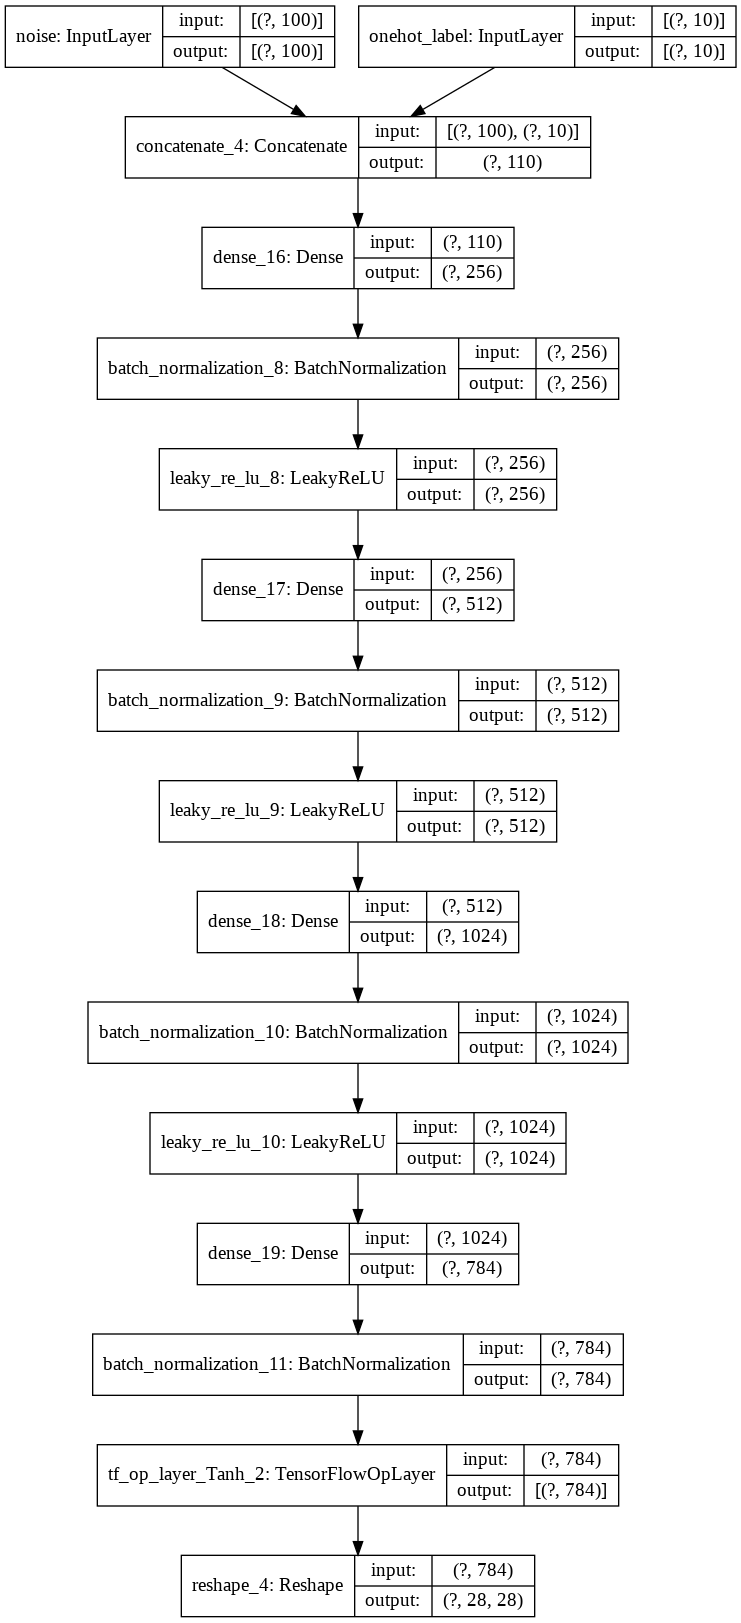

In [0]:
G_3.summary()
tf.keras.utils.plot_model(G_3, 'dense_generator3.png', show_shapes=True)

In [0]:
# Discriminator 모델 작성

image_input_3 = tf.keras.Input(shape=(28, 28), name='image')
label_input_3 = tf.keras.Input(shape=(10,),  name='onehot_label')

image_3 = layers.Reshape(target_shape=(28 * 28, ))(image_input_3)

D_x_3 = layers.concatenate([image_3, label_input_3], axis=-1)
D_x_3 = layers.Dense(1024)(D_x_3)
D_x_3 = layers.LeakyReLU()(D_x_3)
D_x_3 = layers.Dropout(0.3)(D_x_3)
D_x_3 = layers.Dense(512)(D_x_3)
D_x_3 = layers.Dropout(0.3)(D_x_3)
D_x_3 = layers.Dense(256)(D_x_3)
D_y_pred_3 = layers.Dense(1)(D_x_3)

D_3 = tf.keras.Model(inputs=[image_input_3, label_input_3], outputs=D_y_pred_3)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 784)          0           image[0][0]                      
__________________________________________________________________________________________________
onehot_label (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 794)          0           reshape_5[0][0]                  
                                                                 onehot_label[0][0]         

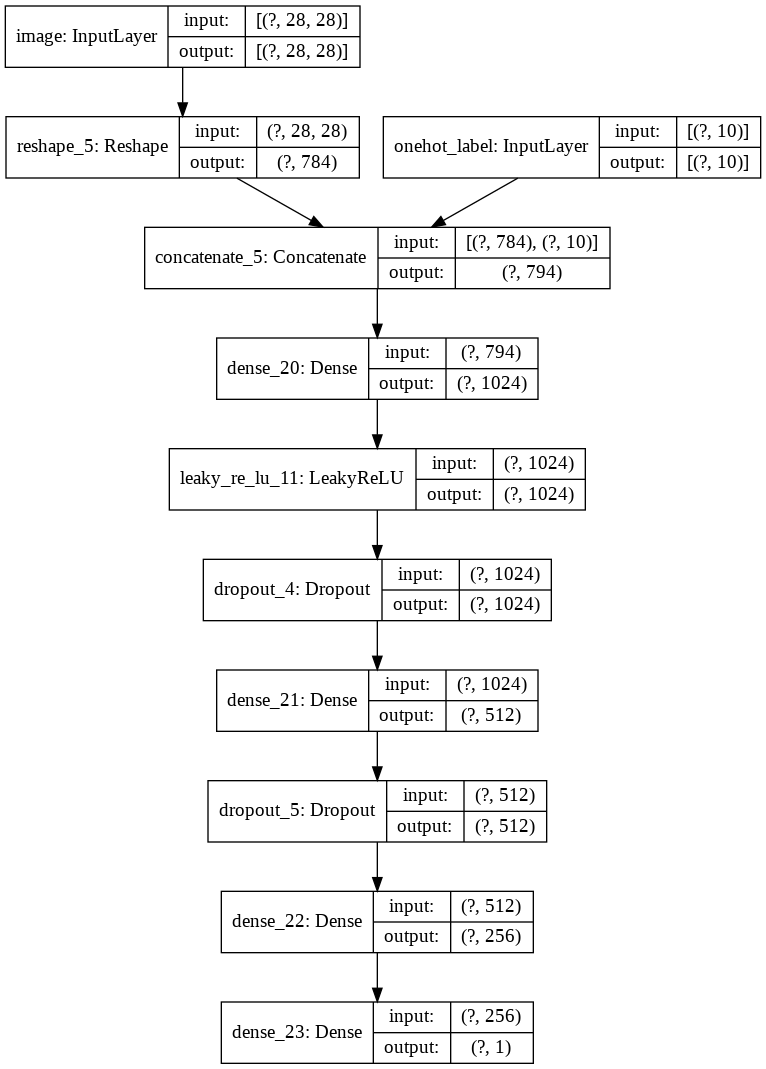

In [0]:
D_3.summary()
tf.keras.utils.plot_model(D_3, 'dense_discriminator3.png', show_shapes=True)

[one example test] rand_label: [8]


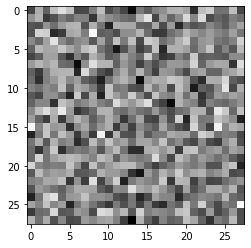

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

rand_label_3 = np.random.randint(10, size=(1,))
print("[one example test] rand_label:", rand_label_3)

test_noise_3 = tf.random.normal([1, 100])
test_label_3 = tf.keras.utils.to_categorical(rand_label_3, num_classes=10)
fake_image_test_3 = G_3([test_noise_3, test_label_3], training=False)  # 생성자 G를 함수로 쓸 때는 training=False로 설정해야 함.

plt.imshow(fake_image_test_3[0], cmap='gray')

In [0]:
# Discriminator에게 generator가 만든 노이즈 영상을 보여주고, 판단을 내릴 수 있는 테스트 함.

decision_3 = D_3([fake_image_test_3, test_label_3], training=False)  # 판별자 D를 함수로 쓸 때는 training=False로 설정해야 함.
print(decision_3)

tf.Tensor([[0.5981109]], shape=(1, 1), dtype=float32)


In [0]:
# GAN 트레이닝에 쓰일 cross-entropy fuctor 정의

cross_entropy_3 = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Discriminator loss 정의

def D_loss_3(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
# Generator loss 정의

def G_loss_3(fake_output):
  return cross_entropy_3(tf.ones_like(fake_output), fake_output)

In [0]:
# GAN 트레이닝에 쓰일 optimizer 정의

G_optimizer_3 = tf.keras.optimizers.Adam(1e-4)
D_optimizer_3 = tf.keras.optimizers.Adam(1e-4)

## 바로 이전의 실험 처럼 300 에포크로 설정하였다.

In [0]:
# 학습 루프 설정

EPOCHS_3 = 300
noise_dim_3 = 100

seed_3 = tf.random.normal([BATCH_SIZE, noise_dim_3])

In [0]:
# 배치단위 학습 함수 설정 (* AutoGraph 기능 쓰기!)

@tf.function
def train_step_3(real_images, real_labels):
  
  assert real_images.shape[0] == real_labels.shape[0]
  
  minibatch_size = real_labels.shape[0]
  noises = tf.random.normal([minibatch_size, noise_dim_3])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G_3([noises, real_labels], training=True)
    
    real_output = D_3([real_images, real_labels], training=True)
    fake_output = D_3([fake_images, real_labels], training=True)
    
    gen_loss_3 = G_loss_3(fake_output)
    dsc_loss_3 = D_loss_3(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss_3, G_3.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss_3, D_3.trainable_variables)
  
  G_optimizer_3.apply_gradients(zip(gen_gradients, G_3.trainable_variables)) 
  D_optimizer_3.apply_gradients(zip(dsc_gradients, D_3.trainable_variables))

In [0]:
def test_step_3(real_images, real_labels):
  
  assert real_images.shape[0] == real_labels.shape[0]
  
  minibatch_size = real_labels.shape[0]
  noises = tf.random.normal([minibatch_size, noise_dim_3])
  
  fake_images = G_3([noises, real_labels], training=False)
  
  real_output = D_3([real_images, real_labels], training=False)
  fake_output = D_3([fake_images, real_labels], training=False)    
  
  gen_loss = G_loss_3(fake_output)
  dsc_loss = D_loss_3(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [0]:
# 학습 함수

def train_3(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for i, batch in enumerate(dataset):
      train_step_3(batch[0], batch[1])
      if i == 0:
        test_step_3(batch[0], batch[1])
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) 

## Generator와 Discriminator의 loss를 관찰해보았다.
* loss가 이전 실험들과 같이 진동을 하였지만 Generator의 loss는 전반적으로 줄어들었고, Discriminator의 로스는 전반적으로 늘어났다.
* 하지만 바로 이전 실험보다 Generator의 loss는 마지막 에포크에서 더 큰 로스 값을 가졌고, Discriminator의 loss는 마지막 에포크에서 좀 더 작은 로스 값을 가졌다.
* 이를 통해 이전 실험보다 손글씨를 의미있게 생성해내지 못할 것을 예상해본다.

In [0]:
# 학습!!!
%%time
train_3(train_dataset_3, EPOCHS_3)

Generator loss: 0.6510034 Discriminator loss: 0.76295274
Time for epoch 1 is 4.122713088989258 sec
Generator loss: 14.581147 Discriminator loss: 8.895436e-05
Time for epoch 2 is 1.4864976406097412 sec
Generator loss: 28.93091 Discriminator loss: 0.00014212441
Time for epoch 3 is 1.5277297496795654 sec
Generator loss: 43.846817 Discriminator loss: 0.0028767535
Time for epoch 4 is 1.4940063953399658 sec
Generator loss: 39.282978 Discriminator loss: 0.00014197413
Time for epoch 5 is 1.5052165985107422 sec
Generator loss: 40.373035 Discriminator loss: 0.0028735409
Time for epoch 6 is 1.5228562355041504 sec
Generator loss: 38.12617 Discriminator loss: 6.98427e-06
Time for epoch 7 is 1.514692783355713 sec
Generator loss: 28.765064 Discriminator loss: 3.7190055e-06
Time for epoch 8 is 1.4998464584350586 sec
Generator loss: 25.989788 Discriminator loss: 1.9604302e-06
Time for epoch 9 is 1.5136888027191162 sec
Generator loss: 29.08146 Discriminator loss: 4.2499305e-06
Time for epoch 10 is 1.505

## 예상대로 바로 이전의 실험보다 더 못한 생성 모델이 되었음을 알 수 있다.
* 이 모델 구조에서는 데이터 전처리를 위와 같이 해서 학습 하는 것은 좋은 방향이 아닌 것 같다.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


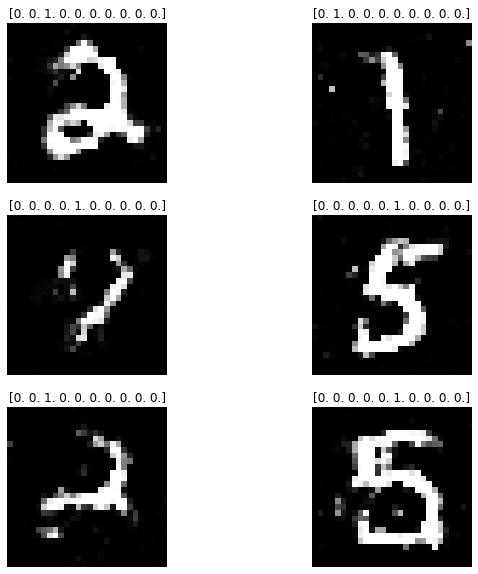

In [0]:
# Generator가 만들어 낸 노이즈 이미지 테스트 해보기

import matplotlib.pyplot as plt

rand_labels_3 = np.random.randint(10, size=(50,))

noises_3 = tf.random.normal([50, 100])
rand_labels_3 = tf.keras.utils.to_categorical(rand_labels_3, num_classes=10)

generated_image_3 = G_3([noises_3, rand_labels_3], training=False)

fig_3, axes_3 = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes_3.flat:
  ax.axis('off')
axes_3[0,0].imshow(generated_image_3[0], cmap='gray')
axes_3[0,0].title.set_text(rand_labels_3[0])
axes_3[0,1].imshow(generated_image_3[1], cmap='gray')
axes_3[0,1].title.set_text(rand_labels_3[1])
axes_3[1,0].imshow(generated_image_3[2], cmap='gray')
axes_3[1,0].title.set_text(rand_labels_3[2])
axes_3[1,1].imshow(generated_image_3[3], cmap='gray')
axes_3[1,1].title.set_text(rand_labels_3[3])
axes_3[2,0].imshow(generated_image_3[4], cmap='gray')
axes_3[2,0].title.set_text(rand_labels_3[4])
axes_3[2,1].imshow(generated_image_3[5], cmap='gray')
axes_3[2,1].title.set_text(rand_labels_3[5])

plt.show()

In [0]:
## 디코더의 테스트 입력 설정

import matplotlib.pyplot as plt
import ipywidgets as widgets

i_3=widgets.IntSlider(min=0, max=49)
ui_3 = widgets.HBox([i_3])

# Generator가 만들어 낸 노이즈 이미지 테스트 해보기


rand_labels_3 = np.random.randint(10, size=(50,))

noises_3 = tf.random.normal([50, 100])
rand_labels_3 = tf.keras.utils.to_categorical(rand_labels_3, num_classes=10)

generated_image_3 = G_3([noises_3, rand_labels_3], training=False)



def z_test_3(i):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  for ax in axes.flat:
    ax.axis('off')
  axes[0,0].imshow(generated_image_3[i], cmap='gray')
  number = np.where(1 == rand_labels_3[i])
  axes[0,0].title.set_text("rand_label number = " + str(number[0][0]))
  plt.show()

out_3 = widgets.interactive_output(z_test_3, {'i':i_3})
display(ui_3, out_3)

Output()